In [3]:
# pip install imblearn

     |████████████████████████████████| 194kB 7.1MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import string
import warnings
import math
import nltk
import json
from langdetect import detect
from sklearn import preprocessing
from libsvm import *
from nltk.stem import PorterStemmer
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
import dask.dataframe as dd
import multiprocessing
import swifter
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('words')
from spellchecker import SpellChecker
from imblearn.over_sampling import SMOTE

spell = SpellChecker()

# pd.set_option('display.max_colwidth', None)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anishajauhari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/anishajauhari/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [4]:
#### Loading Target Values 
target = pd.read_csv("../../data/target.csv")

In [5]:
target = target.drop(columns = ["Unnamed: 0"])

## Classification 

In [6]:
def convertToSparse(df):
    df_sparse = csr_matrix(df.iloc[:, :], dtype=np.int8).toarray()
    return pd.DataFrame(df_sparse, index = df.index, columns = df.columns[:])

In [7]:
def trainTestSplit(df, y):
    return train_test_split(df, y, test_size=0.20, random_state=42)

In [8]:
def trainTestSplitWithImbalancedClassHandling(df, y):
    ### Applying SMOTE Algorithm ###
    df = df.drop(columns = ["index"])
    sm = SMOTE(random_state = 2)
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.20, random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    return X_train, X_test, y_train, y_test

In [9]:
def model_fit(X_train, y_train, model = "NB"):
    if model == "NB":
        NB_Classifier = MultinomialNB()
        model = NB_Classifier.fit(X_train, y_train)
    elif model == "SVM":
        model = OneVsRestClassifier(BaggingClassifier(
            SVC(kernel='rbf', probability=True, class_weight='balanced'), 
                max_samples=1.0 / 10, 
                n_estimators=10))
        model.fit(X_train, y_train)
    else:
        rf = RandomForestClassifier(max_depth = 2, random_state = 0)
        model = rf.fit(X_train, y_train)
    return model

In [10]:
def evaluate_model(y_test, y_pred, model_name):
    print("\nConfusion Matrix : "+model_name)
    print(confusion_matrix(y_test, y_pred))
    print("\n*******************************")
    print("\nClassification Report : "+model_name)
    print(classification_report(y_test, y_pred))

In [17]:
predicted_nb = []
predicted_rf = []
predicted_svm = []
def run_model(df):
    convertToSparse(df)
    X_train, X_test_original, y_train, y_test = trainTestSplitWithImbalancedClassHandling(df, target)
    trans = MinMaxScaler()
    
    X_train = trans.fit_transform(X_train)
    X_test = trans.fit_transform(X_test_original)
    
    model = model_fit(X_train, y_train, "NB")
    y_pred = model.predict(X_test)
    y_pred_changed = pd.Series(y_pred, index = y_test.index)
    evaluate_model(y_test, y_pred, "NB")
    predicted_nb = y_pred
    X_test_nb = X_test_original
    X_test_nb["prediction"] = predicted_nb
    X_test_nb["target_value"] = y_test
    print(predicted_nb)
    print("--- Naive Bayes Misclassification ---")
    
    model = model_fit(X_train, y_train, "RF")
    y_pred = model.predict(X_test)
    y_pred_changed = pd.Series(y_pred, index = y_test.index)
    predicted_rf = y_pred
    print(predicted_rf)
    evaluate_model(y_test, y_pred, "RF")
    X_test_rf = X_test_original
    X_test_rf["prediction"] = predicted_rf
    X_test_rf["target_value"] = y_test

    
#     model = model_fit(X_train, y_train, "SVM")
#     y_pred = model.predict(X_test)
#     y_pred_changed = pd.Series(y_pred, index = y_test.index)
#     print("--- SVM Misclassification ---")
#     evaluate_model(y_test, y_pred, "SVM")
    return (X_test_nb, X_test_rf)

### Experiment 2 - TFIDF

In [18]:
features = pd.read_csv("../../data/features_expt_2.csv")
features = features[0:-1]
features.drop(columns=["Unnamed: 0"], inplace = True)
features.shape ### HACK -- Need to fix

(125543, 517)

In [19]:
predicted_nb, predicted_rf = run_model(features)
predicted_nb


Confusion Matrix : NB
[[ 3680  2475]
 [ 5737 13217]]

*******************************

Classification Report : NB
              precision    recall  f1-score   support

           0       0.39      0.60      0.47      6155
           1       0.84      0.70      0.76     18954

    accuracy                           0.67     25109
   macro avg       0.62      0.65      0.62     25109
weighted avg       0.73      0.67      0.69     25109

[1 0 1 ... 0 1 1]
--- Naive Bayes Misclassification ---
[1 1 0 ... 1 1 1]

Confusion Matrix : RF
[[ 2560  3595]
 [ 3558 15396]]

*******************************

Classification Report : RF
              precision    recall  f1-score   support

           0       0.42      0.42      0.42      6155
           1       0.81      0.81      0.81     18954

    accuracy                           0.72     25109
   macro avg       0.61      0.61      0.61     25109
weighted avg       0.71      0.72      0.71     25109



,misspelled_words,unique_words,slang_words,danceability,energy,key,loudness,mode,speechiness,acousticness,...,years,yes,yet,youd,youll,young,youre,youve,prediction,target_value
82716,0,23,1,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1,1
13072,1,50,4,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.171823,0.000000,1,1
14556,0,58,2,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.043964,0,0
9209,2,70,1,0.512,0.817,7.0,-3.154,1.0,0.142,0.0505,...,0.000000,0.0,0.0,0.035827,0.027693,0.0,0.037459,0.000000,0,1
28256,0,44,1,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,...,0.000000,0.0,0.0,0.000000,0.051451,0.0,0.034797,0.101638,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49236,0,36,3,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.028809,0.000000,0,0
3419,0,48,3,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,...,0.048256,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1,1
60932,0,42,0,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1,1
104351,0,24,0,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1,0


### Experiment 2 - IG

In [ ]:
features_ig = pd.read_csv("../../data/features_expt_2_ig.csv")
features_ig = features_ig[0:-1]
features_ig.drop(columns=["Unnamed: 0"], inplace = True)
features_ig.shape ### HACK -- Need to fix

In [ ]:
run_model(features_ig)

### Analysing TFIDF Models 

In [75]:
run_model(tfidf_df_100)

--- Naive Bayes Misclassification ---
--- False Pos Results ---
24002     0
46011     0
135453    0
1621      0
87593     0
dtype: int8
24002     1
46011     1
135453    1
1621      1
87593     1
dtype: int8


,song,year,artist,genre,lyrics,filtered_lyrics
24002,henry,2010-01-01,emma dean,Pop,Aching to be in the room 'cos no one can tell ...,aching room cos one tell everythings going way...
46011,i need a disguise,2014-01-01,belinda carlisle,Pop,There's a mask on the wall That I should be we...,theres mask wall wearing keep seeing im really...
135453,wow,2006-01-01,brandy,Pop,No more sittin' at home at night Waiting for y...,sittin home night waiting come home cry found ...
1621,the homes of donegal,2009-01-01,celtic thunder,Pop,I just dropped in to see you all I'll only sta...,dropped see ill stay awhile want hear youre ge...
87593,time of year,2006-01-01,ashanti,Pop,Christmas is the time of year That we become a...,christmas time year become one tears joy heart...


--- Random Forest Misclassification ---
--- False Pos Results ---
24002     0
46011     0
135453    0
1621      0
87593     0
dtype: int8
24002     1
46011     1
135453    1
1621      1
87593     1
dtype: int8


,song,year,artist,genre,lyrics,filtered_lyrics
24002,henry,2010-01-01,emma dean,Pop,Aching to be in the room 'cos no one can tell ...,aching room cos one tell everythings going way...
46011,i need a disguise,2014-01-01,belinda carlisle,Pop,There's a mask on the wall That I should be we...,theres mask wall wearing keep seeing im really...
135453,wow,2006-01-01,brandy,Pop,No more sittin' at home at night Waiting for y...,sittin home night waiting come home cry found ...
1621,the homes of donegal,2009-01-01,celtic thunder,Pop,I just dropped in to see you all I'll only sta...,dropped see ill stay awhile want hear youre ge...
87593,time of year,2006-01-01,ashanti,Pop,Christmas is the time of year That we become a...,christmas time year become one tears joy heart...


--- SVM Misclassification ---
--- False Neg Results ---
131846    1
21115     1
14633     1
90017     1
61905     1
dtype: int8
131846    0
21115     0
14633     0
90017     0
61905     0
dtype: int8


,song,year,artist,genre,lyrics,filtered_lyrics
131846,maybe then someday,2005-01-01,abandoned pools,Rock,What's this thing that's haunting me Won't my ...,whats thing thats haunting wont mind let sober...
21115,daughter of light,2007-01-01,carole king,Rock,Daughter of light You're a welcome sight To a ...,daughter light youre welcome sight weary soul ...
14633,baby don t you lie to me,2015-01-01,fratellis,Rock,Well little girl you can roll your eyes At the...,well little girl roll eyes sight everything sp...
90017,ideology,2014-01-01,billy bragg,Rock,When one voice rules the nation Just because t...,one voice rules nation theyre top pile doesnt ...
61905,sorry,2007-01-01,daughtry,Rock,Will you listen to my story? It just be a minu...,listen story minute explain whatever happened ...


--- False Pos Results ---
169862    0
196460    0
168066    0
178700    0
194214    0
dtype: int8
169862    1
196460    1
168066    1
178700    1
194214    1
dtype: int8


,song,year,artist,genre,lyrics,filtered_lyrics
169862,in danger,2010-01-01,aaron fresh,Pop,"Ohh Noo Noo, No ( Verse 1 ) He Told You Lies F...",ohh noo noo verse told lies long everyone s...
196460,brave face,2007-01-01,delta goodrem,Pop,Put your brave face on The one you wore when y...,put brave face one wore stole heart wont hold ...
168066,she works hard for the money,2012-01-01,american idol,Pop,She works hard for the money So hard for it ho...,works hard money hard honey works hard money b...
178700,tender love,2015-01-01,exo,Pop,English Translation: Come to the inner side of...,english translation come inner side sidewalk i...
194214,have fun,2006-01-01,diana ross,Pop,"Hey, everybody Have fun again I want you to ha...",hey everybody fun want fun fun want fun like l...


In [81]:
display(rock_pop_dataset.loc[131846])

song                                              maybe then someday
year                                                      2005-01-01
artist                                               abandoned pools
genre                                                           Rock
lyrics             What's this thing that's haunting me Won't my ...
filtered_lyrics    whats thing thats haunting wont mind let sober...
Name: 131846, dtype: object

In [ ]:
run_model(tfidf_df_200)

run_model(tfidf_df_500)

### Analysing Information Gain Models

In [ ]:
run_model(ig_100)

--- Naive Bayes Misclassification ---
--- False Neg Results ---
21115    1
14633    1
42768    1
5054     1
30473    1
dtype: int8
21115    0
14633    0
42768    0
5054     0
30473    0
dtype: int8


,song,year,artist,genre,lyrics,filtered_lyrics
21115,daughter of light,2007-01-01,carole king,Rock,Daughter of light You're a welcome sight To a ...,daughter light youre welcome sight weary soul ...
14633,baby don t you lie to me,2015-01-01,fratellis,Rock,Well little girl you can roll your eyes At the...,well little girl roll eyes sight everything sp...
42768,skin for scars,2007-01-01,cauterize,Rock,Tie these hands they shake too much To hold yo...,tie hands shake much hold hold wandering eyes ...
5054,don t say a word,2003-01-01,crooked fingers,Rock,Don't say a word. Don't tell me what you heard...,dont say word dont tell heard theres something...
30473,new day rising,2011-01-01,the answer,Rock,[Verse 1] All around the sky? s are falling do...,verse around sky falling new kind sound smile...


--- False Pos Results ---
135453    0
126282    0
196460    0
140363    0
155999    0
dtype: int8
135453    1
126282    1
196460    1
140363    1
155999    1
dtype: int8


,song,year,artist,genre,lyrics,filtered_lyrics
135453,wow,2006-01-01,brandy,Pop,No more sittin' at home at night Waiting for y...,sittin home night waiting come home cry found ...
126282,beautiful,2014-01-01,enrique iglesias,Pop,"You, you are so beautiful It used to be, you a...",beautiful used love like world around could fa...
196460,brave face,2007-01-01,delta goodrem,Pop,Put your brave face on The one you wore when y...,put brave face one wore stole heart wont hold ...
140363,why oh why,2006-01-01,atc,Pop,Do da n de da n dai (Do da n de da n dai) It's...,da n de da n dai da n de da n dai feeling got ...
155999,la hallucinations,2015-01-01,carly rae jepsen,Pop,I remember being naked We were young freaks ju...,remember naked young freaks fresh la never car...


--- Random Forest Misclassification ---
--- False Pos Results ---
24002     0
46011     0
135453    0
1621      0
87593     0
dtype: int8
24002     1
46011     1
135453    1
1621      1
87593     1
dtype: int8


,song,year,artist,genre,lyrics,filtered_lyrics
24002,henry,2010-01-01,emma dean,Pop,Aching to be in the room 'cos no one can tell ...,aching room cos one tell everythings going way...
46011,i need a disguise,2014-01-01,belinda carlisle,Pop,There's a mask on the wall That I should be we...,theres mask wall wearing keep seeing im really...
135453,wow,2006-01-01,brandy,Pop,No more sittin' at home at night Waiting for y...,sittin home night waiting come home cry found ...
1621,the homes of donegal,2009-01-01,celtic thunder,Pop,I just dropped in to see you all I'll only sta...,dropped see ill stay awhile want hear youre ge...
87593,time of year,2006-01-01,ashanti,Pop,Christmas is the time of year That we become a...,christmas time year become one tears joy heart...


In [ ]:
# rock_pop_dataset.iloc[126282]

In [35]:
run_model(ig_200)


Confusion Matrix : NB
[[ 2267  3888]
 [ 2603 16351]]

*******************************

Classification Report : NB
              precision    recall  f1-score   support

           0       0.47      0.37      0.41      6155
           1       0.81      0.86      0.83     18954

    accuracy                           0.74     25109
   macro avg       0.64      0.62      0.62     25109
weighted avg       0.72      0.74      0.73     25109


Confusion Matrix : RF
[[    0  6155]
 [    0 18954]]

*******************************

Classification Report : RF
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6155
           1       0.75      1.00      0.86     18954

    accuracy                           0.75     25109
   macro avg       0.38      0.50      0.43     25109
weighted avg       0.57      0.75      0.65     25109


Confusion Matrix : SVM
[[ 3147  3008]
 [ 3680 15274]]

*******************************

Classification Report : SVM

In [33]:
run_model(ig_500)


Confusion Matrix : NB
[[ 2740  3415]
 [ 2948 16006]]

*******************************

Classification Report : NB
              precision    recall  f1-score   support

           0       0.48      0.45      0.46      6155
           1       0.82      0.84      0.83     18954

    accuracy                           0.75     25109
   macro avg       0.65      0.64      0.65     25109
weighted avg       0.74      0.75      0.74     25109


Confusion Matrix : RF
[[    0  6155]
 [    0 18954]]

*******************************

Classification Report : RF
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6155
           1       0.75      1.00      0.86     18954

    accuracy                           0.75     25109
   macro avg       0.38      0.50      0.43     25109
weighted avg       0.57      0.75      0.65     25109


Confusion Matrix : SVM
[[ 3257  2898]
 [ 3815 15139]]

*******************************

Classification Report : SVM

In [3]:
rockpopdataset = pd.read_csv("../../data/rockpopdataset_exp2.csv")

In [31]:
# X_test["predicted_nb"] = predicted_nb
# X_test["predicted_rf"] = predicted_rf
# rockpopdataset["predicted_svm"] = predicted_svm
rockpopdataset


,Unnamed: 0,song,year,artist,genre,filtered_lyrics,misspelled_words,unique_words,slang_words,danceability,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0,ego remix,2009-01-01,beyonce knowles,Pop,oh baby know im gonna cut right chase women ma...,0,95,3,0.574,...,1.0,-5.443,1.0,0.174,0.0989,0.0,0.0568,0.341,78.781,283933.0
1,1,then tell me,2009-01-01,beyonce knowles,Pop,playin everything easy like seem sure still wa...,0,78,5,0.000,...,0.0,0.000,0.0,0.000,0.0000,0.0,0.0000,0.000,0.000,0.0
2,2,honesty,2009-01-01,beyonce knowles,Pop,search tenderness isnt hard find love need liv...,0,63,2,0.000,...,0.0,0.000,0.0,0.000,0.0000,0.0,0.0000,0.000,0.000,0.0
3,3,you are my rock,2009-01-01,beyonce knowles,Pop,oh oh oh oh oh oh verse wrote book stand titl...,0,83,4,0.000,...,0.0,0.000,0.0,0.000,0.0000,0.0,0.0000,0.000,0.000,0.0
4,4,black culture,2009-01-01,beyonce knowles,Pop,party people people party popping sitting arou...,1,27,1,0.000,...,0.0,0.000,0.0,0.000,0.0000,0.0,0.0000,0.000,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125546,125546,photographs you are taking now,2014-01-01,damon albarn,Pop,photographs youre taking taken heavy clouds hi...,1,59,0,0.000,...,0.0,0.000,0.0,0.000,0.0000,0.0,0.0000,0.000,0.000,0.0
125547,125547,you and me,2014-01-01,damon albarn,Pop,met moko jumbie walks stilts saints row lookin...,4,66,0,0.000,...,0.0,0.000,0.0,0.000,0.0000,0.0,0.0000,0.000,0.000,0.0
125548,125548,hollow ponds,2014-01-01,damon albarn,Pop,chill hollow ponds set sail kid heat wave hit ...,0,36,0,0.000,...,0.0,0.000,0.0,0.000,0.0000,0.0,0.0000,0.000,0.000,0.0
125549,125549,the selfish giant,2014-01-01,damon albarn,Pop,celebrate passing drugs put back seat theyre c...,1,45,0,0.000,...,0.0,0.000,0.0,0.000,0.0000,0.0,0.0000,0.000,0.000,0.0


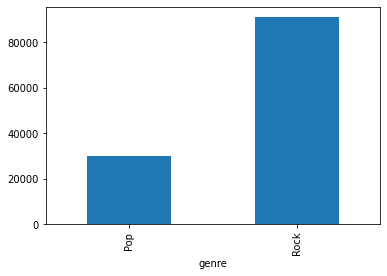

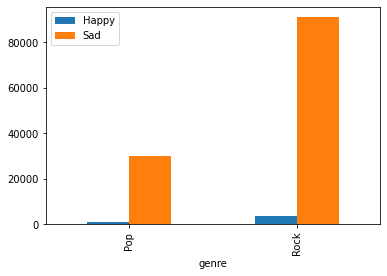

In [23]:
happy = rockpopdataset[rockpopdataset["valence"]>0.5].groupby(by=["genre"]).count()
sad = rockpopdataset[rockpopdataset["valence"]<=0.5].groupby(by=["genre"]).count()
happy["valence"].plot(kind="bar")
sad["valence"].plot(kind="bar")
mood = pd.merge(happy, sad, left_index =True, right_index = True)
fig, ax = plt.subplots()
mood[["valence_x", "valence_y"]].plot(kind="bar",ax = ax)
ax.legend(["Happy", "Sad"])

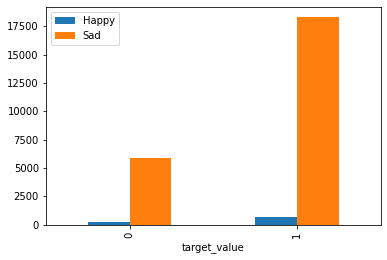

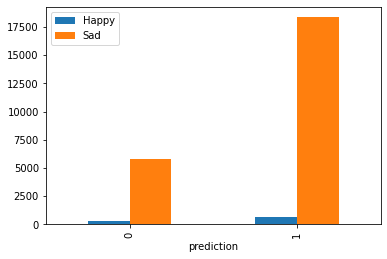

In [29]:
### Naive Bayes
happy = predicted_nb[predicted_nb["valence"]>0.5].groupby(by=["target_value"]).count()
sad = predicted_nb[predicted_nb["valence"]<=0.5].groupby(by=["target_value"]).count()
# happy["valence"].plot(kind="bar")
# sad["valence"].plot(kind="bar")
mood = pd.merge(happy, sad, left_index =True, right_index = True)
fig, ax = plt.subplots()
mood[["valence_x", "valence_y"]].plot(kind="bar",ax = ax)
ax.legend(["Happy", "Sad"])

happy = predicted_nb[predicted_nb["valence"]>0.5].groupby(by=["prediction"]).count()
sad = predicted_nb[predicted_nb["valence"]<=0.5].groupby(by=["prediction"]).count()
# happy["valence"].plot(kind="bar")
# sad["valence"].plot(kind="bar")
mood = pd.merge(happy, sad, left_index =True, right_index = True)
fig, ax = plt.subplots()
mood[["valence_x", "valence_y"]].plot(kind="bar",ax = ax)
ax.legend(["Happy", "Sad"])



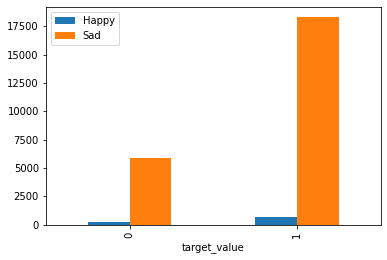

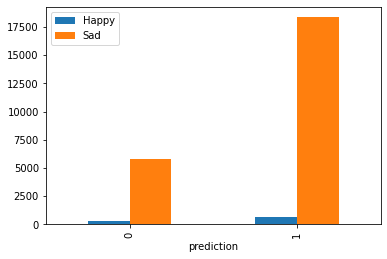

In [30]:
### Random Forest
happy = predicted_rf[predicted_rf["valence"]>0.5].groupby(by=["target_value"]).count()
sad = predicted_rf[predicted_rf["valence"]<=0.5].groupby(by=["target_value"]).count()
# happy["valence"].plot(kind="bar")
# sad["valence"].plot(kind="bar")
mood = pd.merge(happy, sad, left_index =True, right_index = True)

fig, ax = plt.subplots()
mood[["valence_x", "valence_y"]].plot(kind="bar",ax = ax)
ax.legend(["Happy", "Sad"])


happy = predicted_rf[predicted_rf["valence"]>0.5].groupby(by=["prediction"]).count()
sad = predicted_rf[predicted_rf["valence"]<=0.5].groupby(by=["prediction"]).count()
# happy["valence"].plot(kind="bar")
# sad["valence"].plot(kind="bar")
mood = pd.merge(happy, sad, left_index =True, right_index = True)
fig, ax = plt.subplots()
mood[["valence_x", "valence_y"]].plot(kind="bar",ax = ax)
ax.legend(["Happy", "Sad"])



In [4]:
import pandas as pd
def clean_data(data):
    #convert tweets to lower case
    data['filtered_lyrics'] = data['filtered_lyrics'].str.lower()
    stop = set(stopwords.words('english'))

    #url removes
    data['filtered_lyrics'] = data['filtered_lyrics'].str.replace(r'(https|http)?:\/(\w|\.|\/|\?|\=|\&|\%)*\b','')
    data['filtered_lyrics'] = data['filtered_lyrics'].str.replace(r'www\.\S+\.com','')

    #removes retweets & cc
    data['filtered_lyrics'] = data['filtered_lyrics'].str.replace(r'rt|cc', '')

    #hashtags removes
    data['filtered_lyrics'] = data['filtered_lyrics'].str.replace(r'#\S+', '')

    #user mention removes
    data['filtered_lyrics'] = data['filtered_lyrics'].str.replace(r'@\S+', '')

    #emoji 
    data['filtered_lyrics'] = data['filtered_lyrics'].str.replace(r'[^\x00-\x7F]+', '')

    #html tags
    data['filtered_lyrics'] = data['filtered_lyrics'].str.replace(r'<.*?>', '')

    #removes extra spaces
    data['filtered_lyrics'] = data['filtered_lyrics'].str.replace(r' +', ' ')

    #punctuation
    data['filtered_lyrics'] = data['filtered_lyrics'].str.replace('[{}]'.format(string.punctuation), '')

#     #stop words removes
#     data['Text'] = data['Text'].apply(lambda x: [item for item in x if item not in stop])

#     #convert preprocessed list words to string 
#     data['Text'] = data['Text'].apply(' '.join)
    return data


import spacy
import string
nlp = spacy.load("en_core_web_sm")
import nltk
from nltk.corpus import stopwords

def pos_tagging(data):
    req_tag = ['NN']
    extracted_words = []
    i = 0
    try:
        for ind, x in data.iterrows():
            doc = nlp(x["filtered_lyrics"])
            for token in doc:
                i += 1
                if token.tag_ in req_tag and token.shape_ != 'x' and token.shape_ != 'xx' and token.shape_ != 'xxx':
                    extracted_words.append(token.lemma_)
        return extracted_words
    except Exception as e:
        print("Exception", e)
        return extracted_words

extracted_words = []
data = clean_data(rockpopdataset)
extract_words = pos_tagging(data)
extracted_words.append(extract_words)

extracted_words = [item for t in extracted_words for item in t]
from collections import Counter
word_freq = Counter(extracted_words)
print(word_freq.most_common(10))

[('love', 133175), ('time', 94648), ('baby', 69010), ('life', 53961), ('night', 47740), ('world', 41707), ('girl', 35465), ('nothing', 31617), ('cause', 30324), ('chorus', 27982)]


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anishajauhari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


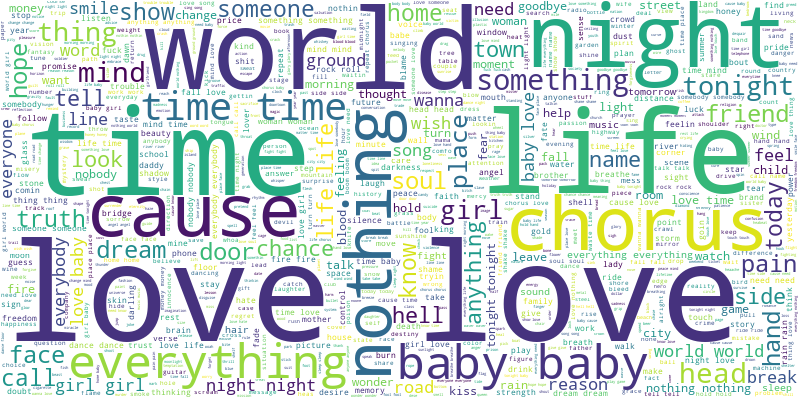

In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(stopwords.words('portuguese'))
stop_words.extend(stopwords.words('french'))
stop_words.extend(stopwords.words('german'))

from wordcloud import WordCloud

long_string = ','.join(list(extracted_words))
wordcloud = WordCloud(width = 800, height = 400,background_color="white", max_words=1000, contour_width=5, contour_color='steelblue', stopwords = stop_words)
wordcloud.generate(long_string)
wordcloud.to_image()